<u><h1>Imports</u></h1>

In [ ]:
import pandas as pd
import numpy as np
import joblib
import statsmodels.api as sm
import pandas as pd
from itertools import combinations
from tqdm import tqdm


<u><h1>Load data</u></h1>

In [ ]:
# Load the data
data = pd.read_csv('/content/video_games_df_final.csv')
data.drop(columns=['img', 'na_sales','jp_sales','pal_sales','other_sales'], inplace=True)

data.head(10)

,title,console,genre,publisher,developer,critic_score,total_sales,release_date,last_update,is_sequal,iso_year,iso_week,year_week,niche_count,na_sales_avg_temp,jp_sales_avg_temp,pal_sales_avg_temp,special_sales_day_count,days_since_release,month
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,2013-09-17,NaN,1,2013.0,38.0,2013-W38,6,20.179375,23.971556,13.531111,0,3959,9
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,2014-11-18,03-01-2018,1,2014.0,47.0,2014-W47,1,5.952656,13.182000,8.546667,3,3532,11
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,2002-10-28,NaN,1,2002.0,44.0,2002-W44,12,12.779637,17.682796,9.494624,0,7936,10
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,2013-09-17,NaN,1,2013.0,38.0,2013-W38,7,20.179375,23.971556,13.531111,0,3959,9
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,2015-11-06,14-01-2018,1,2015.0,45.0,2015-W45,16,9.330674,14.025111,8.598889,3,3179,11
5,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,2011-11-08,NaN,1,2011.0,45.0,2011-W45,33,8.673712,13.987778,9.598889,3,4638,11
6,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,2010-11-09,NaN,1,2010.0,45.0,2010-W45,33,7.616966,12.193111,5.304444,3,5002,11
7,Red Dead Redemption 2,PS4,Action-Adventure,Rockstar Games,Rockstar Games,9.8,13.94,2018-10-26,02-11-2018,1,2018.0,43.0,2018-W43,1,13.652186,18.284946,10.393548,0,2094,10
8,Call of Duty: Black Ops II,X360,Shooter,Activision,Treyarch,8.4,13.86,2012-11-13,07-04-2018,1,2012.0,46.0,2012-W46,33,7.370514,11.649111,6.354444,3,4267,11
9,Call of Duty: Black Ops II,PS3,Shooter,Activision,Treyarch,8.0,13.80,2012-11-13,07-04-2018,1,2012.0,46.0,2012-W46,27,7.370514,11.649111,6.354444,3,4267,11


<u><h1>Calculate the Pairwise ATE Based on the Casual Graph</u></h1>

In [ ]:

# Function to perform the bootstrap procedure
def bootstrap_ate(data_subset,bootstrap_iterations):
    bootstrap_estimates = []

    # Perform bootstrap sampling
    for _ in tqdm(range(bootstrap_iterations)):
        # Sample with replacement
        resampled_data = data_subset.sample(n=len(data_subset), replace=True)

        # Re-fit the model with the resampled data
        X_resampled = resampled_data[['special_sales_day_count', 'is_sequal', 'niche_count']]
        X_resampled = sm.add_constant(X_resampled)  # Add constant
        y_resampled = resampled_data['total_sales']    # Ensure y contains the same variable
        T_resampled = resampled_data['treatment_binary']    # Ensure T contains the same binary treatment variable
        X_resampled['treatment_binary'] = T_resampled
        # Fit OLS model
        model = sm.OLS(y_resampled, X_resampled, missing='drop')
        result = model.fit()

        # Store the ATE (coefficient of the treatment variable)
        bootstrap_estimates.append(result.params['treatment_binary'])

    # Calculate 95% CI (alpha=0.05)
    lower_bound = np.percentile(bootstrap_estimates, 100 * (alpha / 2))
    upper_bound = np.percentile(bootstrap_estimates, 100 * (1 - alpha / 2))

    return np.mean(bootstrap_estimates), lower_bound, upper_bound


In [ ]:
# Assuming `data` has columns: 'outcome', 'treatment', 'covariate1', 'covariate2'
# Example of how to perform pairwise comparison for treatments

treatments = data['month'].unique()  # List of treatment groups, e.g., [1, 2, 3, ..., 12]
results = {}
results = []
bootstrap_iterations = 500  # Number of bootstrap samples
alpha = 0.05

for t1, t2 in combinations(treatments, 2):
    # Create a binary treatment variable for the pairwise comparison
    data_subset = data[(data['month'] == t1) | (data['month'] == t2)]
    data_subset['treatment_binary'] = (data_subset['month'] == t1).astype(int)

    # Perform bootstrapping to calculate ATE and CI

    ate, ci_lower, ci_upper = bootstrap_ate(data_subset, bootstrap_iterations)


    # Store results
    results.append({
        'treatment_pair': (t1, t2),
        'ATE': ate,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    })

results_df = pd.DataFrame(results)



<ipython-input-9-c0477d6d6d41>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['treatment_binary'] = (data_subset['month'] == t1).astype(int)
100%|██████████| 500/500 [00:03<00:00, 135.65it/s]
<ipython-input-9-c0477d6d6d41>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['treatment_binary'] = (data_subset['month'] == t1).astype(int)
100%|██████████| 500/500 [00:03<00:00, 126.90it/s]
<ipython-input-9-c0477d6d6d41>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [ ]:
# import pandas as pd
# import joblib

# Saving DataFrames
results_df.to_csv("results.csv")
# pairwise_ate_df.to_csv("pairwise_ate_df.csv")

# Saving the model
# joblib.dump(cate_model, "cate_model.pkl")  # Replace `your_model` with your model's variable name


In [ ]:
print(results_df)

   treatment_pair       ATE  CI_lower  CI_upper
0         (9, 11)  0.070066  0.045723  0.096525
1         (9, 10) -0.071802 -0.124526 -0.020035
2          (9, 4)  0.155666  0.098586  0.210520
3          (9, 6)  0.087815  0.044465  0.137541
4          (9, 5)  0.110516  0.085241  0.135262
..            ...       ...       ...       ...
61         (1, 2)  0.029294  0.008871  0.052210
62        (1, 12)  0.150314  0.127746  0.174913
63         (7, 2) -0.059452 -0.094255 -0.025716
64        (7, 12)  0.065980  0.054438  0.078179
65        (2, 12)  0.088381  0.074132  0.102576

[66 rows x 4 columns]


## Plot Results

In [1]:
import pandas as pd

results_df = pd.read_csv('results_final.csv')
results_df.head(10)

,Unnamed: 0,treatment_pair,ATE,CI_lower,CI_upper
0,0,"(9, 11)",0.070066,0.045723,0.096525
1,1,"(9, 10)",-0.071802,-0.124526,-0.020035
2,2,"(9, 4)",0.155666,0.098586,0.210520
3,3,"(9, 6)",0.087815,0.044465,0.137541
4,4,"(9, 5)",0.110516,0.085241,0.135262
5,5,"(9, 8)",0.071787,0.017847,0.122831
6,6,"(9, 3)",0.138991,0.095187,0.189360
7,7,"(9, 1)",0.103145,0.076364,0.129334
8,8,"(9, 7)",0.178550,0.133814,0.228937
9,9,"(9, 2)",0.120132,0.074780,0.167321


In [2]:
# Initialize the dictionaries
cate_results = {}
cate_conf_intervals = {}
p_values = {}

# Fill the dictionaries with the data from the dataframe
for _, row in results_df.iterrows():
    treatment_pair = row['treatment_pair']
    month1, month2 = map(int, treatment_pair.strip('()').split(', '))
    cate = row['ATE']
    ci_lower = row['CI_lower']
    ci_upper = row['CI_upper']
    
    # Initialize the month pairs if not already present in the dictionary
    if month1 not in cate_results:
        cate_results[month1] = {}
        cate_conf_intervals[month1] = {}
        p_values[month1] = {}
    
    # Assign the ATE, confidence intervals, and p-value
    cate_results[month1][month2] = cate
    cate_conf_intervals[month1][month2] = (ci_lower, ci_upper)
    p_values[month1][month2] = 1  # Since there are no p-values, we assign 1 to all

# Now `cate_results`, `cate_conf_intervals`, and `p_values` are ready to be used in the `plot_cate_results` function


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cate_results(cate_results, cate_conf_intervals, p_values):
    # Flatten data for easier plotting
    month_pairs = []
    cates = []
    ci_lowers = []
    ci_uppers = []
    pvals = []
    
    for month in cate_results:
        for other_month in cate_results[month]:
            month_pairs.append(f"{month}-{other_month}")
            cates.append(cate_results[month][other_month])
            ci_lowers.append(cate_conf_intervals[month][other_month][0])
            ci_uppers.append(cate_conf_intervals[month][other_month][1])
            pvals.append(p_values[month][other_month])
    
    # Calculate error bars as the difference between CATE and confidence bounds
    ci_errors = [ [cate - ci_lower, ci_upper - cate] for cate, ci_lower, ci_upper in zip(cates, ci_lowers, ci_uppers)]
    ci_errors = np.array(ci_errors).T  # Transpose to separate lower and upper error bars
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot CATE values as dots
    plt.scatter(month_pairs, cates, color='yellow', edgecolor='black', s=100, zorder=5)
    
    # Plot error bars (confidence intervals)
    for idx in range(len(month_pairs)):
        plt.plot([month_pairs[idx], month_pairs[idx]], [ci_lowers[idx], ci_uppers[idx]], color='black', lw=2)
    
    # Annotate significant CATEs with *
    significance_level = 0.05
    for idx in range(len(month_pairs)):
        if pvals[idx] <= significance_level:
            plt.text(month_pairs[idx], cates[idx] + max(ci_errors[:, idx]) * 0.05,
                     "*", ha='center', va='bottom', fontsize=14, color='red')
    
    # Labels and title
    plt.xlabel("Month Pairs")
    plt.ylabel("CATE")
    plt.title("CATE Results with Confidence Intervals (Significant Results Marked with *)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



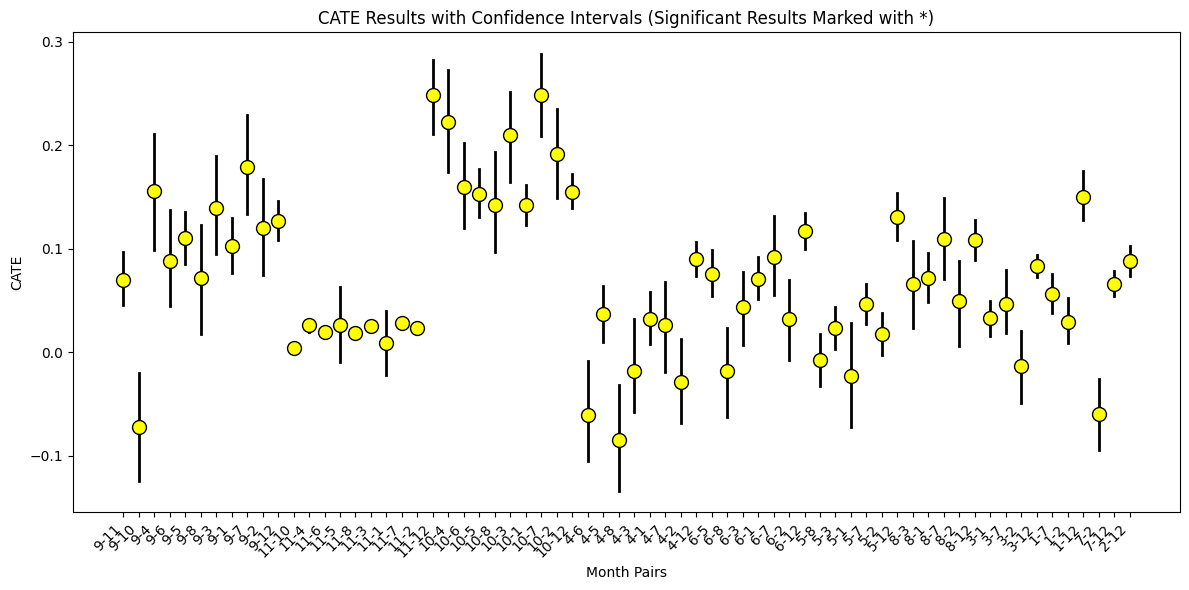

In [5]:
plot_cate_results(cate_results, cate_conf_intervals, p_values)